# Regresja Liniowa
Łukasz Klimkiewicz, 244822

In [1]:
# Powszechne importy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# Numer indeksu
index = 244822

In [3]:
# Wartości pochodne
seed = index
n_samples = int(str(index)[0:2] + str(index)[-2:])
print(f'seed: {seed}; samples: {n_samples}')

seed: 244822; samples: 2422


## Pomocnicze funkcje

In [4]:
# Funkcja uruchamiająca program FlapPy Bird
import os

def flappy(seed=seed, input_=None, output=None, speed=None):
    args = ""
    if seed: args += f"--seed {seed} "
    if input_: args += f"-i {input_} "
    if output: args += f"-o {output} "
    if speed: args += f"--speed {speed} "
    os.system(f'cd flappybird && python flappy.py {args}')

In [5]:
# Uruchamienie gry z sekwencją wejściową
def flappy_replay(regressor):
    x = np.arange(0, 6000)
    x[:250] = 68
    y = regressor.predict(x.reshape(-1, 1)).flatten()
    df = pd.DataFrame({'x': x, 'y': y})
    df.to_csv('flappybird/input.csv', header=False, index=False)
    flappy(input_='input.csv', speed=10)

In [6]:
# Zbieranie danych FlapPy Bird
import ipywidgets as widgets

collect_text = widgets.Text(description="Nazwa pliku")
collect_button = widgets.Button(description="Zbieraj dane")
collect_box = widgets.HBox([collect_button, collect_text])

def flappybird_collect(e):
    flappy(output=r'..\datasets\\' + collect_text.value + '.csv')

collect_button.on_click(flappybird_collect)
display(collect_box)

In [7]:
# Plot common legend for whole figure insted for every ax separately
def plt_legend_combined(fig, margin=0.02, space=0.06):
    lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]
    lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
    d = {label: line for line, label in zip(lines, labels)}
    labels = list(d.keys())
    lines = list(d.values())
    fig.legend(lines, labels)
    fig.tight_layout(rect=(margin, margin, 1-margin, 1-space))

In [8]:
# Błąd średniokwadratowy
def mean_squared_error(true_values, predictions):
    return np.sum((true_values-predictions)**2)

## Zbiory danych
Generowanie i wczytywanie zbiorów danych

### Zbiór danych syntetycznych

In [9]:
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split

# Generowanie
syn_x, syn_y = make_regression(n_samples=n_samples, noise=16, random_state=seed, n_features=1)

# Podział na zbiory
syn_train_x, syn_test_x, syn_train_y, syn_test_y = train_test_split(syn_x, syn_y, test_size=.2, random_state=seed)

syn_data = {
    'train': {
        'x': syn_train_x,
        'y': syn_train_y.reshape(-1, 1)
    },
    'test': {
        'x': syn_test_x,
        'y': syn_test_y.reshape(-1, 1)
    }
}

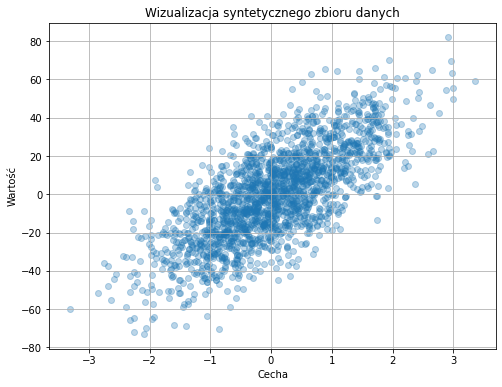

In [10]:
# Wizualizacja
fig, ax = plt.subplots(figsize=(8, 6))
ax.scatter(syn_data['train']['x'], syn_data['train']['y'], alpha=0.3)
ax.grid()
ax.set_ylabel('Wartość')
ax.set_xlabel('Cecha')
ax.set_title('Wizualizacja syntetycznego zbioru danych');

### Zbiory danych FlapPy Bird

In [11]:
# Wczytywanie
bird_single = pd.read_csv('datasets/single_points.csv', names=['x', 'y'])
bird_key = pd.read_csv('datasets/key_points.csv', names=['x', 'y'])
bird_all = pd.read_csv('datasets/all_points.csv', names=['x', 'y'])

bird_data = {
    'single': {
        'x': bird_single.x.values.reshape(-1, 1),
        'y': bird_single.y.values.reshape(-1, 1),
    },
    'key': {
        'x': bird_key.x.values.reshape(-1, 1),
        'y': bird_key.y.values.reshape(-1, 1),
    },
    'all': {
        'x': bird_all.x.values.reshape(-1, 1),
        'y': bird_all.y.values.reshape(-1, 1),
    },
}

bird_subsets_names = ['single', 'key', 'all']

bird_x_range = np.arange(250, bird_key.x.values[-1])

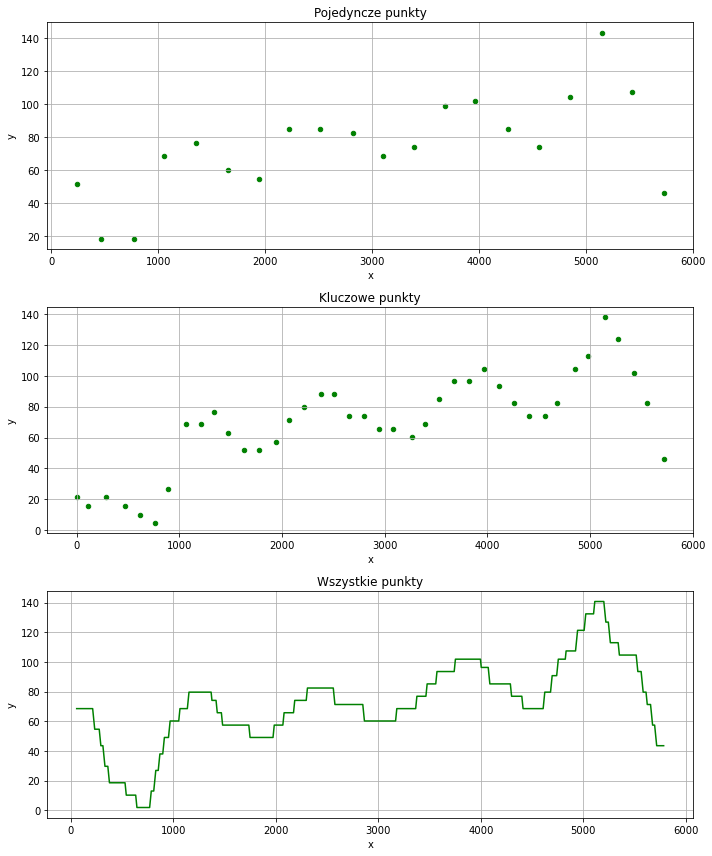

In [12]:
# Wizualizacja
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 12))
bird_single.plot.scatter('x', 'y', c='g', ax=ax1)
bird_key.plot.scatter('x', 'y', c='g', ax=ax2)
bird_all.sort_values('x').plot('x', 'y', c='g', ax=ax3, legend=False, ylabel='y')

ax1.set_title('Pojedyncze punkty')
ax2.set_title('Kluczowe punkty')
ax3.set_title('Wszystkie punkty')

ax1.grid()
ax2.grid()
ax3.grid()

fig.tight_layout();

## Implementacja
Implementacja poszczególnych metod regresji

### Regresja numeryczna

In [13]:
from sklearn.base import BaseEstimator

class CustomNumericLinearRegression(BaseEstimator):

    def __init__(self, fit_intercept=True):
        self.fit_intercept = fit_intercept
        self.coefficients = None
        self.intercept = None

    @staticmethod
    def loss(theta, X, y):
        theta = np.column_stack([theta])
        return np.squeeze((y-(X@theta)).T@(y-(X@theta)))

    def fit(self, X, y):
        if self.fit_intercept:
            X = np.hstack([X, np.ones((X.shape[0], 1))])

        # Core logic
        start_theta = np.random.random((X.shape[1],))
        res = minimize(self.loss, start_theta, method='Powell', args=(X, y))
        theta = res.x.reshape(-1, 1)

        if self.fit_intercept:
            self.coefficients = theta[:-1, 0]
            self.intercept = theta[-1, 0]
        else:
            self.coefficients = theta

        return self

    def predict(self, X):
        theta = self.coefficients
        result = X@theta
        if self.fit_intercept:
            result += self.intercept
        return np.column_stack([result])

### Regresja analityczna

In [14]:
from sklearn.base import BaseEstimator
from scipy.optimize import minimize

class CustomAnalyticLinearRegression(BaseEstimator):

    def __init__(self, fit_intercept=True):
        self.fit_intercept = fit_intercept
        self.coefficients = None
        self.intercept = None

    def fit(self, X, y):
        if self.fit_intercept:
            X = np.hstack([X, np.ones((X.shape[0], 1))])

        # Core logic
        theta = np.linalg.inv(X.T.dot(X)).dot(X.T).dot(y)

        if self.fit_intercept:
            self.coefficients = theta[:-1, 0]
            self.intercept = theta[-1, 0]
        else:
            self.coefficients = theta

        return self

    def predict(self, X):
        theta = self.coefficients
        result = X@theta
        if self.fit_intercept:
            result += self.intercept
        return np.column_stack([result])

### Regresja z regularyzacją Tichonowa

In [15]:
from sklearn.base import BaseEstimator

class CustomRidge(BaseEstimator):

    def __init__(self, alpha, fit_intercept=True):
        self.alpha = alpha
        self.fit_intercept = True
        self.coefficients = None
        self.intercept = None

    def fit(self, X, y):
        if self.fit_intercept:
            X = np.hstack([X, np.ones((X.shape[0], 1))])

        # Core logic
        d = X.shape[1]
        A = self.alpha*np.identity(d)
        theta = np.linalg.inv(X.T.dot(X)+A).dot(X.T).dot(y)

        if self.fit_intercept:
            self.coefficients = theta[:-1, 0]
            self.intercept = theta[-1, 0]
        else:
            self.coefficients = theta

        return self

    def predict(self, X):
        theta = self.coefficients
        result = X@theta
        if self.fit_intercept:
            result += self.intercept
        return np.column_stack([result])

### Standaryzacja

In [16]:
from sklearn.base import BaseEstimator, TransformerMixin

class CustomStandardScaler(BaseEstimator, TransformerMixin):

    def __init__(self):
        self.mean = None
        self.std = None

    def fit(self, X, y=None):
        self.mean = np.mean(X, axis=0).reshape(1, -1)
        self.std = np.std(X, axis=0).reshape(1, -1)
        return self

    def transform(self, X, y=None):
        ones = np.ones((X.shape[0], 1))
        mean_matrix = ones@self.mean
        std_matrix = ones@self.std
        return (X - mean_matrix) / std_matrix

## Porównania

### Porównanie metody numerycznej i analitycznej na zbiorze syntetycznym
- Na ocenę 3

#### Uczenie modeli

In [17]:
analytic_model = CustomAnalyticLinearRegression(fit_intercept=False)
numeric_model = CustomNumericLinearRegression(fit_intercept=False)

analytic_model.fit(syn_data['train']['x'], syn_data['train']['y'])
numeric_model.fit(syn_data['train']['x'], syn_data['train']['y']);

#### Wizualizacja wyników regresji

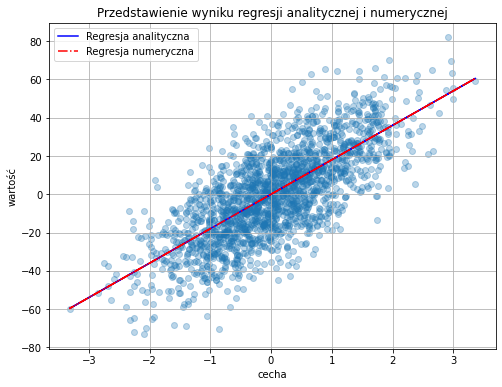

In [18]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.scatter(syn_data['train']['x'], syn_data['train']['y'], alpha=0.3)

analytic_predictions = analytic_model.predict(syn_data['train']['x'])
numeric_predictions = numeric_model.predict(syn_data['train']['x'])

ax.plot(syn_data['train']['x'], analytic_predictions, c='b', label='Regresja analityczna')
ax.plot(syn_data['train']['x'], numeric_predictions, c='r', label='Regresja numeryczna', linestyle='-.')

ax.grid()
ax.set_xlabel('cecha')
ax.set_ylabel('wartość')
ax.set_title('Przedstawienie wyniku regresji analitycznej i numerycznej')
ax.legend();

#### Mean Squared Errors

In [19]:
analytic_test_predictions = analytic_model.predict(syn_data['test']['x'])
numeric_test_predictions = numeric_model.predict(syn_data['test']['x'])

analytic_mse = mean_squared_error(syn_data['test']['y'], analytic_test_predictions)
numeric_mse = mean_squared_error(syn_data['test']['y'], numeric_test_predictions)

print(f'Analytic MSE: {analytic_mse}')
print(f'Numeric MSE : {numeric_mse}')
print(f'Difference  : {abs(analytic_mse-numeric_mse)}')

Analytic MSE: 119118.97747621064
Numeric MSE : 119118.97750655343
Difference  : 3.0342795071192086e-05


Dokładność metod jest porónywalna. Dla metody analitycznej jest nieco lepsza.

#### Pomiar czasów wykonywania

In [20]:
# Pomiar czasów
import timeit

analytic_model_t = CustomAnalyticLinearRegression()
numeric_model_t = CustomNumericLinearRegression()

def time_analytic_fit():
    analytic_model_t.fit(syn_data['train']['x'], syn_data['train']['y'])

def time_analytic_predict():
    analytic_model_t.predict(syn_data['test']['x'])

def time_numeric_fit():
    numeric_model_t.fit(syn_data['train']['x'], syn_data['train']['y'])

def time_numeric_predict():
    numeric_model_t.predict(syn_data['test']['x'])


time_af = timeit.timeit(time_analytic_fit, number=1000) / 1000
time_ap = timeit.timeit(time_analytic_predict, number=1000) / 1000
time_nf = timeit.timeit(time_numeric_fit, number=1000) / 1000
time_np = timeit.timeit(time_numeric_predict, number=1000) / 1000

index = ['Nauka', 'Przewidywanie']
time_df = pd.DataFrame({'Analityczna': [time_af, time_ap], 'Numeryczna': [time_nf, time_np]}, index=index)
time_df

,Analityczna,Numeryczna
Nauka,0.000089,0.002474
Przewidywanie,0.000013,0.000014


Dla obu modeli przewidywanie zajmuję tyle samo czasu, lecz nauka w metodzie numerycznej zajmuję wielokrotnie więcej czasu.

### Porównanie sklearn i własnej metody analitycznej na zbiorze FlapPy Bird
- Na wszystkich zbiorach z FlapPy Bird wielomianem 9 i 21 rzędu
- Na ocenę 4

#### Dokonanie obliczeń

In [21]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

polynomial_degrees_note4 = [9, 21]

results_note4 = {}

for subset_name in bird_subsets_names:

    subset_results = {}
    results_note4[subset_name] = subset_results

    for degree in polynomial_degrees_note4:

        degree_results = {}
        subset_results[degree] = degree_results

        for regressor_name, Regressor in [
            ('custom', CustomAnalyticLinearRegression), 
            ('scikit', LinearRegression)
        ]:

            regressor_results = {}
            degree_results[regressor_name] = regressor_results

            model = make_pipeline(
                CustomStandardScaler(),
                PolynomialFeatures(degree=degree, include_bias=False),
                Regressor(fit_intercept=True)
            )

            model.fit(bird_data[subset_name]['x'], bird_data[subset_name]['y'])

            bird_fly_predictions = model.predict(bird_x_range.reshape(-1, 1))

            predictions_for_mse = model.predict(bird_data[subset_name]['x'])
            mse = mean_squared_error(bird_data[subset_name]['y'], predictions_for_mse)

            regressor_results['model'] = model
            regressor_results['predictions'] = bird_fly_predictions
            regressor_results['mse'] = mse

#### Wizualizacja wyników regresji

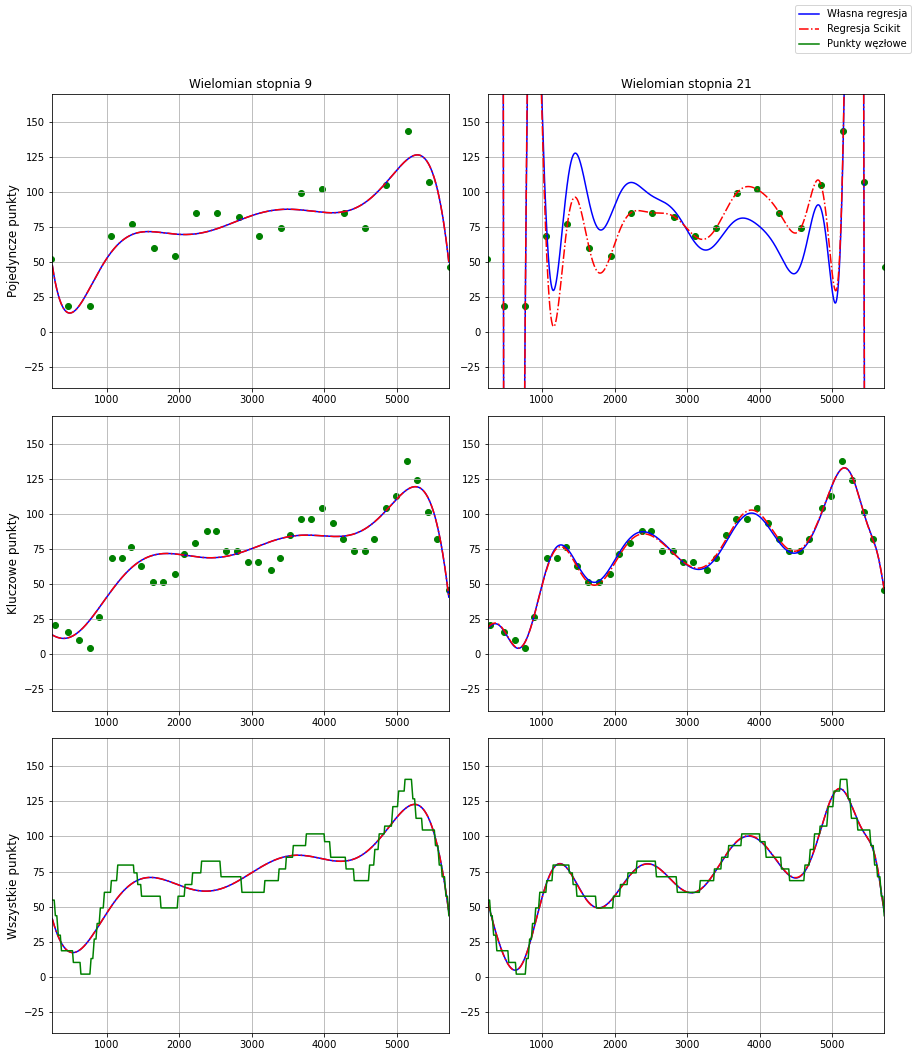

In [22]:
fig, axs = plt.subplots(len(bird_subsets_names), len(polynomial_degrees_note4), figsize=(13, 15))

for row, subset in enumerate(bird_subsets_names):

    for col, degree in enumerate(polynomial_degrees_note4):

        ax = axs[row][col]

        custom_predictions = results_note4[subset][degree]['custom']['predictions']
        scikit_predictions = results_note4[subset][degree]['scikit']['predictions']

        ax.plot(bird_x_range, custom_predictions, c='b', label='Własna regresja')
        ax.plot(bird_x_range, scikit_predictions, c='r', label='Regresja Scikit', linestyle='-.')

        subset_x = bird_data[subset]['x']
        subset_y = bird_data[subset]['y']

        if subset == 'all':
            indices = np.argsort(subset_x, axis=0)
            ax.plot(subset_x[indices].reshape((-1, 1)), subset_y[indices].reshape((-1, 1)), c='g', label='Punkty węzłowe')
        else:
            ax.scatter(subset_x, subset_y, c='g', label='Punkty węzłowe')

        ax.grid()
        ax.set_ylim((-40, 170))
        ax.set_xlim((bird_x_range[0], bird_x_range[-1]))

for col, title in enumerate(['Wielomian stopnia 9', 'Wielomian stopnia 21']):
    axs[0][col].set_title(title, size='large')
for row, title in enumerate(['Pojedyncze punkty', 'Kluczowe punkty', 'Wszystkie punkty']):
    axs[row][0].set_ylabel(title, size='large')

plt_legend_combined(fig)

Wykresy dla własnej oraz dostarczonej przez scikit metody regresji w znaczącej liczbie przypadków się pokrywają. Wyjątkiem jest wielomian 21 stopnia dla pojedynczych punktów. Obserwowane, dziwne zachowanie własnej metody jest spowodowane zapewne tym, że liczba punktów węzłowych jest mniejsza od stopnia wielomianu. Metoda dostarczona w ramach scikit musi posiadać jakieś zabezpieczenie na tą okazję.

#### Uruchomienie FlapPy Bird z wygenerowanymi danymi

In [23]:
import ipywidgets as widgets
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures

degree_options = [(str(degree), degree) for degree in polynomial_degrees_note4]

method_field_note4 = widgets.RadioButtons(options=['scikit', 'custom'], description='Metoda')
degree_field_note4 = widgets.RadioButtons(options=degree_options, description='Stopień')
subset_field_note4 = widgets.RadioButtons(options=bird_subsets_names, description='Zbiór')
button_note4 = widgets.Button(description='Start')
box_note4 = widgets.VBox([method_field_note4, degree_field_note4, subset_field_note4, button_note4])
display(box_note4)

def start_flappy_with_results_note4(e):
    subset = subset_field_note4.value
    degree = degree_field_note4.value
    regressor = method_field_note4.value
    model = results_note4[subset][degree][regressor]['model']
    flappy_replay(model)

button_note4.on_click(start_flappy_with_results_note4)

#### Wyświetlanie MSE

In [31]:
records = []
for subset in results_note4:
    for degree in results_note4[subset]:
        for regressor in results_note4[subset][degree]:
            records.append((subset, degree, regressor, results_note4[subset][degree][regressor]['mse']))
matrix = np.array(records)

df = pd.DataFrame({
    'Zbiór': matrix[:,0],
    'Stopień': matrix[:,1],
    'Regresor': matrix[:,2],
    'MSE': matrix[:,3], 
})

df = df.pivot(index=['Zbiór', 'Stopień'], columns='Regresor', values='MSE')
# df['custom - scikit'] = df['custom'].astype('float64') - df['scikit'].astype('float64')
df

Regresor                    custom                  scikit
Zbiór  Stopień                                            
all    21        64305.58172581982       64144.81508940908
       9         689756.4400632338       689756.4400632335
key    21       453.89253183102807      385.50925510397076
       9          6063.23149265878       6063.231492658773
single 21        7475.714548384236  2.7856595506336577e-15
       9        2888.6878331142784      2888.6878331142784

Błędy MSE generowane poprzez model własnej implementacji i dostarczony przez scikit są niewielkie. 
Wyjątkiem jest przypadek wielomianu 21 stopnia dla pojedynczych punków.

#### Pomiar czasów wykonania

In [25]:
from sklearn.pipeline import make_pipeline

# Pomiar czasów
records = []

for subset in bird_subsets_names:

    for degree in polynomial_degrees_note4:

        for regressor_name, Regressor in [
            ('custom', CustomAnalyticLinearRegression),
            ('scikit', LinearRegression)
        ]:

            model = make_pipeline(
                CustomStandardScaler(),
                PolynomialFeatures(degree=degree, include_bias=False),
                Regressor(fit_intercept=True)
            )

            def time_fit():
                model.fit(bird_data[subset]['x'], bird_data[subset]['y'])

            def time_predict():
                model.predict(bird_data[subset]['x'])

            fit_time = timeit.timeit(time_fit, number=100) / 100
            predict_time = timeit.timeit(time_predict, number=100) / 100

            record = (subset, degree, regressor_name, fit_time, predict_time)
            records.append(record)

# Tworzenie tabeli
subsets, degrees, regressors, fit, predict = [[record[i] for record in records] for i in range(5)]
columns = {
    'Podzbiór': subsets,
    'Stopień': degrees,
    'Regresor': regressors,
    'Czas nauki': fit,
    'Czas predykcji': predict,
}
metrics_df = pd.DataFrame(columns)
metrics_df.set_index(['Podzbiór', 'Stopień', 'Regresor'], inplace=True)
metrics_df

Czas nauki  Czas predykcji
Podzbiór Stopień Regresor                            
single   9       custom      0.000805        0.000152
                 scikit      0.000798        0.000191
         21      custom      0.000794        0.000224
                 scikit      0.001013        0.000261
key      9       custom      0.000566        0.000154
                 scikit      0.000816        0.000190
         21      custom      0.000796        0.000215
                 scikit      0.000948        0.000258
all      9       custom      0.000975        0.000267
                 scikit      0.001522        0.000300
         21      custom      0.001729        0.000353
                 scikit      0.002177        0.000381

Własna metoda regresji jest zwykle szybsza w nauce i predykcji od metody z biblioteki scikit.

### Porównanie  sklearn i własnej metody ridge regression na zbiorze FlapPy Bird
- Na wszystkich zbiorach z FlapPy Bird wielomianem 16 rzędu
- Na ocenę 5

In [26]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge

alphas_note5 = [0, 1e-4, 1e-2]
degree_note5 = 16

results_note5 = {}

for subset_name in bird_subsets_names:

    subset_results = {}
    results_note5[subset_name] = subset_results

    for alpha in alphas_note5:

        alpha_results = {}
        subset_results[alpha] = alpha_results

        for regressor_name, Regressor in [
            ('custom', CustomRidge),
            ('scikit', Ridge)
        ]:

            regressor_results = {}
            alpha_results[regressor_name] = regressor_results

            model = make_pipeline(
                CustomStandardScaler(),
                PolynomialFeatures(degree=degree_note5, include_bias=False),
                Regressor(alpha=alpha, fit_intercept=True)
            )

            model.fit(bird_data[subset_name]['x'], bird_data[subset_name]['y'])

            bird_fly_predictions = model.predict(bird_x_range.reshape(-1, 1))

            predictions_for_mse = model.predict(bird_data[subset_name]['x'])
            mse = mean_squared_error(bird_data[subset_name]['y'], predictions_for_mse)

            regressor_results['model'] = model
            regressor_results['predictions'] = bird_fly_predictions
            regressor_results['mse'] = mse

#### Wizualizacja wyników regresji

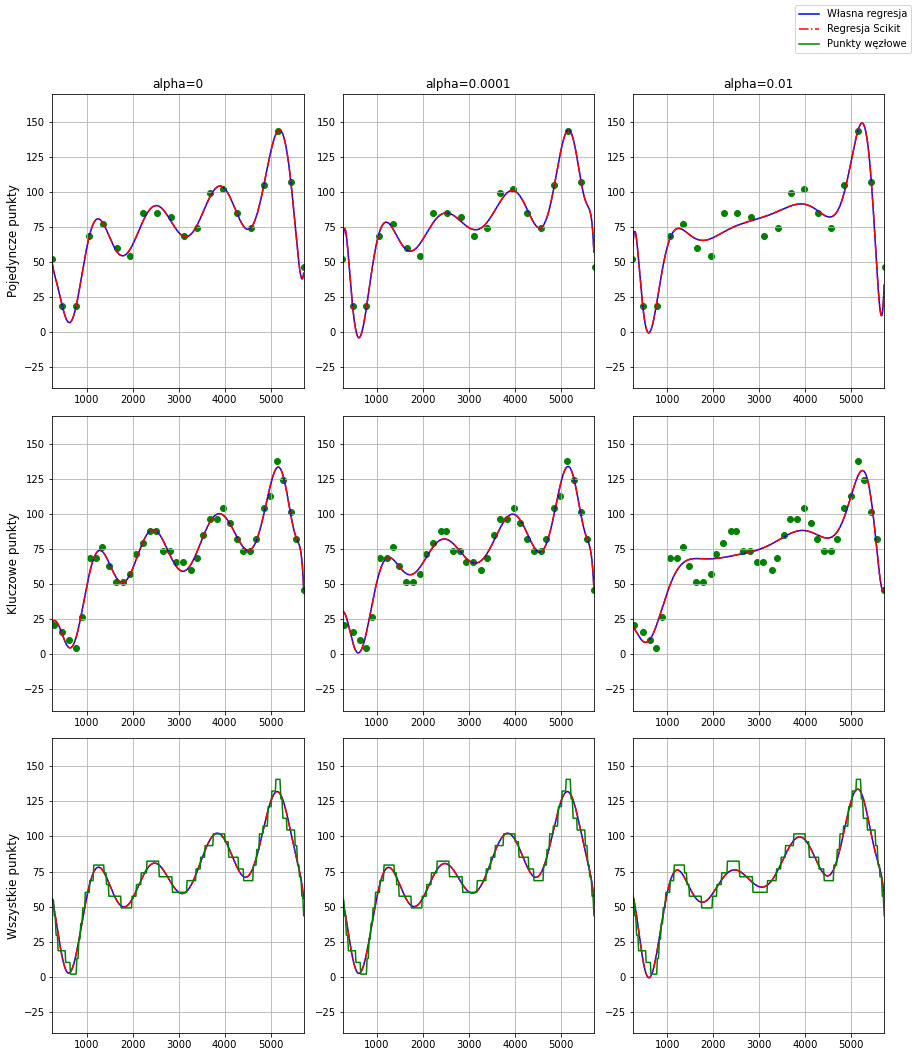

In [27]:
fig, axs = plt.subplots(len(bird_subsets_names), len(alphas_note5), figsize=(13, 15))

for row, subset in enumerate(bird_subsets_names):

    for col, alpha in enumerate(alphas_note5):

        ax = axs[row][col]

        custom_predictions = results_note5[subset][alpha]['custom']['predictions']
        scikit_predictions = results_note5[subset][alpha]['scikit']['predictions']

        ax.plot(bird_x_range, custom_predictions, c='b', label='Własna regresja')
        ax.plot(bird_x_range, scikit_predictions, c='r', label='Regresja Scikit', linestyle='-.')

        subset_x = bird_data[subset]['x']
        subset_y = bird_data[subset]['y']

        if subset == 'all':
            indices = np.argsort(subset_x, axis=0)
            ax.plot(subset_x[indices].reshape((-1, 1)), subset_y[indices].reshape((-1, 1)), c='g', label='Punkty węzłowe')
        else:
            ax.scatter(subset_x, subset_y, c='g', label='Punkty węzłowe')

        ax.grid()
        ax.set_ylim((-40, 170))
        ax.set_xlim((bird_x_range[0], bird_x_range[-1]))

for col, title in enumerate([f'alpha={alpha}' for alpha in alphas_note5]):
    axs[0][col].set_title(title, size='large')
for row, title in enumerate(['Pojedyncze punkty', 'Kluczowe punkty', 'Wszystkie punkty']):
    axs[row][0].set_ylabel(title, size='large')

plt_legend_combined(fig)

Wyniki regresji dla własnej metody oraz z pakietu scikit się wyraźnie pokrywają

#### Uruchomienie FlapPy Bird z uzyskanymi wynikami

In [1]:
import ipywidgets as widgets
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures

alpha_options = [(str(alpha), alpha) for alpha in alphas_note5]

method_field_note5 = widgets.RadioButtons(options=['scikit', 'custom'], description='Metoda')
alpha_field_note5 = widgets.RadioButtons(options=alpha_options, description='Alpha')
subset_field_note5 = widgets.RadioButtons(options=bird_subsets_names, description='Zbiór')
button_note5 = widgets.Button(description='Start')
box_note5 = widgets.VBox([method_field_note5, alpha_field_note5, subset_field_note5, button_note5])
display(box_note5)

def start_flappy_with_results_note5(e):
    subset = subset_field_note5.value
    alpha = alpha_field_note5.value
    regressor = method_field_note5.value
    model = results_note5[subset][alpha][regressor]['model']
    flappy_replay(model)

button_note5.on_click(start_flappy_with_results_note5)

NameError: name 'alphas_note5' is not defined

#### Mean Squared Error

In [29]:
records = []
for subset in results_note5:
    for alpha in results_note5[subset]:
        for regressor in results_note5[subset][alpha]:
            records.append((subset, alpha, regressor, results_note5[subset][alpha][regressor]['mse']))
matrix = np.array(records)

df = pd.DataFrame({
    'Zbiór': matrix[:,0],
    'Alpha': matrix[:,1],
    'Regresor': matrix[:,2],
    'MSE': matrix[:,3], 
})

df = df.pivot(index=['Zbiór', 'Alpha'], columns='Regresor', values='MSE')
# df['custom - scikit'] = df['custom'].astype('float64') - df['scikit'].astype('float64')
df

Regresor                   custom              scikit
Zbiór  Alpha                                         
all    0        83237.02929489732   83237.02929472578
       0.0001   83339.27654187976   83339.28990978551
       0.01    112564.33910414373  112564.83360112325
key    0        570.0579918742862   570.0579918650648
       0.0001  1054.4073997958208   1054.414294564403
       0.01     4029.520134155402  4030.0616228734425
single 0       109.58362477346165  109.58362104558873
       0.0001  243.59714638262258    243.610032884001
       0.01    1106.8378840016646  1107.9454604063324

Średnie błędy kwadratowe dla własnej metody i metody z pakietu scikit są podobne

Regularyzacja nie zmniejsza jednak błędu, ponieważ zwykła metoda regresji, bez regularyzacji, nie przejawia problemu dużych współczynników wielomianu

#### Pomiar czasów

In [30]:
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import Ridge

# Pomiar czasów
records = []

for subset in bird_subsets_names:

    for alpha in alphas_note5:

        for regressor_name, Regressor in [
            ('custom', CustomRidge),
            ('scikit', Ridge)
        ]:

            model = make_pipeline(
                CustomStandardScaler(),
                PolynomialFeatures(degree=degree_note5, include_bias=False),
                Regressor(alpha=alpha, fit_intercept=True)
            )

            def time_fit():
                model.fit(bird_data[subset]['x'], bird_data[subset]['y'])

            def time_predict():
                model.predict(bird_data[subset]['x'])

            fit_time = timeit.timeit(time_fit, number=500) / 500
            predict_time = timeit.timeit(time_predict, number=500) / 500

            record = (subset, alpha, regressor_name, fit_time, predict_time)
            records.append(record)

# Tworzenie tabeli
subsets, alphas, regressors, fit, predict = [[record[i] for record in records] for i in range(5)]
columns = {
    'Podzbiór': subsets,
    'Alpha': alphas,
    'Regresor': regressors,
    'Czas nauki': fit,
    'Czas predykcji': predict,
}
metrics_df = pd.DataFrame(columns)
metrics_df.set_index(['Podzbiór', 'Alpha', 'Regresor'], inplace=True)
metrics_df

Czas nauki  Czas predykcji
Podzbiór Alpha  Regresor                            
single   0.0000 custom      0.000472        0.000114
                scikit      0.000531        0.000143
         0.0001 custom      0.000450        0.000112
                scikit      0.000533        0.000146
         0.0100 custom      0.000571        0.000111
                scikit      0.000503        0.000164
key      0.0000 custom      0.000399        0.000114
                scikit      0.000541        0.000148
         0.0001 custom      0.000429        0.000112
                scikit      0.000495        0.000180
         0.0100 custom      0.000459        0.000112
                scikit      0.000494        0.000165
all      0.0000 custom      0.001058        0.000228
                scikit      0.001131        0.000286
         0.0001 custom      0.001075        0.000228
                scikit      0.001169        0.000285
         0.0100 custom      0.001176        0.000232
                scikit      0.001264        0.000321